## M0 : Quick Start track B **AG News**

### Confirm GPU is ready

In [6]:
!nvidia-smi || echo "nvidia-smi unavailable (CPU runtime)"

Sat Nov 22 13:19:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 577.03                 Driver Version: 577.03         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8              2W /   50W |    1069MiB /   8188MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Point the notebook at the project folder

In [7]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()
elif PROJECT_ROOT.name == "content":
    candidate = PROJECT_ROOT / "nlp-project"
    if candidate.exists():
        PROJECT_ROOT = candidate.resolve()

if not (PROJECT_ROOT / "src").exists():
    raise FileNotFoundError(
        f"Could not locate project root at {PROJECT_ROOT}. Upload or clone nlp-project before proceeding."
    )

os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.append(str(PROJECT_ROOT / "src"))
print(f"Project root: {PROJECT_ROOT}")


Project root: C:\Users\lucas\End-to-End-Deep-Learning-Systems\End-to-End-Deep-Learning-Systems\starters\nlp-project-starter\nlp-project


### Install the project requirement

In [8]:
# Install project dependencies listed in requirements.txt
!pip install -r requirements.txt

### Run the smoke test

In [9]:
from src import smoke_check

smoke_path = smoke_check.run_smoke("configs/nlp_agnews.yaml")
print(smoke_path.read_text())

{
  "loss": 1.3951396942138672,
  "batch_size": 64,
  "seq_len": 69,
  "num_classes": 4
}


# Track B - NLP **AG News**

## M1: Problem Scoping & Data Validation

### 1.1. Problem Definition

L’objectif du Track B est de construire un système de **classification de textes** à partir d’articles journalistiques courts issus du dataset **AG News**.

Chaque exemple est composé de :

- **Input** : un court texte journalistique (titre + description)
- **Output** : une catégorie parmi **4 classes** :
  - `0` → *World*
  - `1` → *Sports*
  - `2` → *Business*
  - `3` → *Sci/Tech*

Il s’agit donc d’un problème de :

- **NLP (Text Classification)**
- **Supervised Learning**
- **Multi-class classification (4 classes)**
- Avec des textes courts (souvent < 40 tokens)

Le modèle entraîné dans ce track est un **LSTM** (recurrent neural network) avec :
- Embedding trainable
- LSTM bidirectionnel
- Classification via une couche linéaire finale

Ce notebook vise à :
1. Comprendre le problème et le dataset  
2. Vérifier la qualité des données  
3. Entraîner un modèle baseline  
4. Évaluer sa performance  
5. Préparer les analyses pour les prochains datasets du Track B

### 1.2. Evaluation Metrics

### 1.2. Evaluation Metrics

Pour ce problème, nous utilisons les métriques classiques en NLP multi-classe :

#### • **Accuracy**
Pourcentage d’exemples correctement classés.  
C’est la métrique principale pour AG News (dataset équilibré).

#### • **Macro F1-score**
Moyenne du F1-score calculé indépendamment pour chaque classe.

Utile car :
- robuste aux déséquilibres
- reflète la qualité d’apprentissage de *toutes* les classes
- permet de vérifier que le modèle ne favorise pas une classe en particulier

#### • **Validation Loss**
Mesure la qualité générale de la modélisation.
Surveille :
- l’overfitting (train ↓, val ↑)
- la convergence du modèle

Ces trois métriques apparaissent dans les fichiers :
- `outputs/log.csv` (historique par epoch)
- `outputs/metrics.json` (meilleur modèle)
- `outputs/eval.json` (test final)


### 1.3. Data Card – AG News

Le dataset **AG News** est un benchmark NLP classique contenant des courts articles classés en 4 catégories.

**Caractéristiques principales :**

| Propriété | Valeur |
|----------|--------|
| Type | Texte (classification multi-classe) |
| Langue | Anglais |
| Nombre de classes | 4 |
| Classes | World, Sports, Business, Sci/Tech |
| Taille train | 120 000 exemples |
| Taille test | 7 600 exemples |
| Format | `{ "text": ..., "label": ... }` |
| Longueur moyenne des textes | ~20–40 tokens |

Ci-dessous, nous chargeons et inspectons les premières instances.

In [10]:
from datasets import load_dataset

ag_news = load_dataset("ag_news")
ag_news


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Nous affichons quelques exemples

In [11]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

for i in range(3):
    ex = ag_news["train"][i]
    print("\n==============================")
    print(f"Example {i}")
    print(f"Label : {ex['label']} ({label_names[ex['label']]})")
    print(f"Text  : {ex['text'][:300]}...")



Example 0
Label : 2 (Business)
Text  : Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....

Example 1
Label : 2 (Business)
Text  : Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market....

Example 2
Label : 2 (Business)
Text  : Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums....


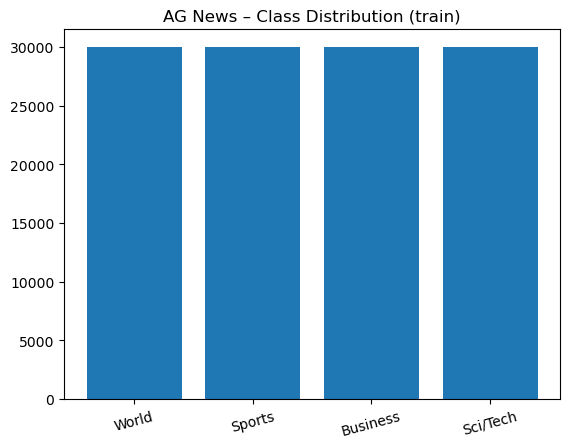

Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

counts = Counter([ex["label"] for ex in ag_news["train"]])
names = [label_names[i] for i in sorted(counts.keys())]
values = [counts[i] for i in sorted(counts.keys())]

plt.figure()
plt.bar(names, values)
plt.title("AG News – Class Distribution (train)")
plt.xticks(rotation=15)
plt.show()

counts


### 1.4. Train / Validation / Test splits

Le dataset AG News contient par défaut deux splits :

- **train** : 120 000 exemples
- **test** : 7 600 exemples

Le starter crée un **split validation interne** en prélevant ~10% du train :
- Environ 108k pour l'entraînement
- Environ 12k pour la validation

Ce split est effectué automatiquement dans `src/data.py`.

Nous vérifions les tailles ci-dessous.

In [13]:
print("Train size :", len(ag_news["train"]))
print("Test size  :", len(ag_news["test"]))

# Dans le projet, la validation est créée manuellement à partir du train
val_size = max(2000, int(0.1 * len(ag_news["train"])))
train_size = len(ag_news["train"]) - val_size

print("Expected train split :", train_size)
print("Expected val split   :", val_size)


Train size : 120000
Test size  : 7600
Expected train split : 108000
Expected val split   : 12000


## M2 – Baseline Model Implementation

### 2.1. Forward Pass Test (One Full Batch)

Nous construisons le modèle LSTM baseline et vérifions qu’un **batch complet**
issu du dataloader AG News passe bien dans le réseau sans erreur.

Cette étape permet de valider que :

- le dataset AG News est correctement chargé,
- le vocabulaire et le padding fonctionnent,
- les dimensions `[batch_size, seq_len]` sont cohérentes,
- le modèle LSTM produit bien des logits de taille `[batch_size, num_classes]`,
- une loss de classification (CrossEntropy) peut être calculée.

On reproduit ainsi le même type de vérification qu’en Track A, mais pour le
pipeline NLP.

In [14]:
print(f"Project root: {PROJECT_ROOT}")

Project root: C:\Users\lucas\End-to-End-Deep-Learning-Systems\End-to-End-Deep-Learning-Systems\starters\nlp-project-starter\nlp-project


In [15]:
from yaml import safe_load
import torch
import torch.nn as nn

from src.data import build_loaders
from src.model import LSTMClassifier

# Charger la config AG News
cfg = safe_load(open("configs/nlp_agnews.yaml", encoding="utf-8"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device =", device)

# Data + vocab
train_loader, val_loader, test_loader, vocab, num_classes, label_names = build_loaders(cfg)
print("Num classes =", num_classes)
print("Vocab size  =", len(vocab.itos))

# Construire le modèle baseline LSTM
m = cfg["model"]

model = LSTMClassifier(
    vocab_size=len(vocab.itos),
    emb_dim=m["emb_dim"],
    hidden_dim=m["hidden_dim"],
    num_layers=m["num_layers"],
    bidirectional=m["bidirectional"],
    dropout=m["dropout"],
    num_classes=num_classes,
    pad_idx=vocab.pad_idx
).to(device)

criterion = nn.CrossEntropyLoss()

# Batch
toks, lens, targets = next(iter(train_loader))
toks    = toks.to(device)
lens    = lens.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(toks, lens)
    loss = criterion(outputs, targets)

print("Tokens shape :", toks.shape)
print("Lengths shape:", lens.shape)
print("Logits shape :", outputs.shape)
print("Batch loss   :", loss.item())


Device = cuda
Num classes = 4
Vocab size  = 30000
Tokens shape : torch.Size([64, 76])
Lengths shape: torch.Size([64])
Logits shape : torch.Size([64, 4])
Batch loss   : 1.3999078273773193


### 2.2 Baseline Training (configuration rapide)

Avant de passer à des expériences plus poussées, nous réalisons un premier
entraînement **rapide** sur AG News afin de valider que :

- le modèle apprend correctement,
- la loss décroît bien,
- le pipeline complet (train → save best → metrics) est opérationnel.

Pour cela, nous utilisons une configuration dédiée :

`nlp_agnews_fast.yaml`, qui reprend la même architecture que
`nlp_agnews.yaml` mais avec **moins d'époques** (2) et un dossier
de sortie séparé (`outputs_fast/`).

Cette exécution constitue notre **baseline** : elle donne une première
estimation des performances du modèle LSTM sur AG News.

In [16]:
# Lancement de l'entraînement baseline "fast"
!python src/train.py --config configs/nlp_agnews_fast.yaml

Done. Best val F1-macro: 0.9027. Checkpoint: outputs_fast\best.pt



train: 100%|█████████▉| 1683/1688 [00:37<00:00, 53.98it/s]
                                                          

val:  95%|█████████▌| 179/188 [00:07<00:00, 115.77it/s]
                                                       

train: 100%|█████████▉| 1687/1688 [00:37<00:00, 55.13it/s]
                                                          

val:  96%|█████████▌| 180/188 [00:07<00:00, 112.42it/s]
                                                       


### 2.3. Baseline Metrics

Après l'entraînement rapide, nous lisons les métriques obtenues
(accuracy et macro-F1) afin d’établir une ligne de départ claire pour
le Track B.

Les fichiers générés par cette config rapide sont écrits dans
`outputs_fast/` :
- `best.pt`
- `log.csv`
- `metrics.json`

In [17]:
import json
from pathlib import Path

metrics_path_fast = Path("outputs_fast/metrics.json")

if metrics_path_fast.exists():
    with open(metrics_path_fast, "r") as f:
        metrics_fast = json.load(f)

    print("=== Baseline (fast) metrics ===")
    for k, v in metrics_fast.items():
        print(f"{k}: {v}")
else:
    print("outputs_fast/metrics.json not found. Vérifie que le training fast a bien terminé.")


=== Baseline (fast) metrics ===
best_val_f1_macro: 0.9027225971221924
label_names: ['World', 'Sports', 'Business', 'Sci/Tech']


In [18]:
import pandas as pd

log_fast = pd.read_csv("outputs_fast/log.csv")
log_fast


,epoch,train_loss,val_loss,val_acc,val_f1_macro
0,1,0.4656,0.3208,0.8874,0.8859
1,2,0.2444,0.2785,0.9027,0.9027


### 2.4. Conclusion du Baseline

Sur le Track B – NLP (AG News), notre configuration **fast**
(`nlp_agnews_fast.yaml`, 2 epochs) atteint :

- **Val accuracy ≈ 0.903**
- **Val Macro-F1 ≈ 0.903**

Les résultats montrent que :

- Le modèle **converge très vite** : dès la première epoch, on dépasse déjà 88% d’accuracy,
  puis on atteint ~90% à la deuxième.
- La **loss de validation continue de baisser** entre l’epoch 1 et 2, ce qui indique qu’il
  n’y a pas encore de sur-apprentissage visible à ce stade.
- Le **Macro-F1** est quasiment identique à l’accuracy, ce qui suggère des performances
  équilibrées sur les 4 classes (World, Sports, Business, Sci/Tech).

Ce run “fast” joue le rôle de **baseline minimale** pour le Track B :

1. Il valide que tout le pipeline (dataloaders → LSTM → entraînement → sauvegarde du
   meilleur modèle → métriques) fonctionne correctement en local.
2. Il fournit une **référence chiffrée** raisonnable (~90% acc / F1 en 2 epochs) pour
   comparer les futurs entraînements plus longs ou les autres datasets NLP.
3. Il montre que le modèle LSTM proposé est déjà très compétitif sur AG News, même
   sans aucun tuning particulier.

## M3 — Optimisation & Régularisation

Dans cette section, nous cherchons à améliorer notre baseline en intégrant plusieurs techniques d’optimisation et de régularisation.  
L’objectif est d’obtenir de meilleures performances que le baseline (val_acc ≈ 90.27%) obtenu en seulement 5 époques.

### 3.1. Stratégies d’optimisation et de régularisation utilisées

Dans ce Track B, notre modèle est un **LSTM de classification de texte** entraîné
sur AG News. La configuration `nlp_agnews_fast.yaml` met en place plusieurs
mécanismes d’optimisation et de régularisation pour stabiliser l’entraînement
et limiter l’overfitting.


#### Optimiseur AdamW + Learning Rate

Nous utilisons l’optimiseur **AdamW**, bien adapté aux données textuelles :

- il combine les avantages d’Adam (adaptation du pas de gradient par paramètre),
- avec une gestion propre du **weight decay** (d’où le “W” de AdamW).

Le taux d’apprentissage (learning rate) est défini directement dans le YAML :

```yaml
train:
  lr: 1e-3        # exemple de valeur
```

Ce learning rate fixe suffit pour notre run “fast” (2 epochs) et permet au modèle
de converger rapidement vers ~90 % de précision.


#### Weight Decay (L2 Regularization)

Le **weight decay** pénalise les poids trop grands et aide à limiter
l’overfitting, surtout avec un réseau récurrent qui peut facilement sur-apprendre
sur un petit nombre d’epochs.

Il est déjà activé dans la config via :

```yaml
train:
  weight_decay: 1e-5    # valeur typique
```

Concrètement, cela ajoute un terme L2 sur les poids du modèle dans la fonction
de coût vue par l’optimiseur.


#### Dropout dans le LSTM

La classe `LSTMClassifier` intègre un **Dropout** appliqué sur la représentation
finale issue du LSTM avant la couche de classification :

```python
self.dropout = nn.Dropout(dropout)
...
h = self.dropout(h)
logits = self.fc(h)
```

Le taux de dropout est contrôlé depuis le YAML :

```yaml
model:
  dropout: 0.3  
```

Ce mécanisme :

* force le modèle à ne pas dépendre d’un petit sous-ensemble de neurones,
* améliore la capacité de généralisation,
* est particulièrement utile en NLP où les représentations peuvent être très
  corrélées.


#### Architecture contrôlée (LSTM bidirectionnel modeste)

La capacité du modèle est également régulée par sa **taille** :

```yaml
model:
  emb_dim: 128
  hidden_dim: 256
  num_layers: 1
  bidirectional: true
```

* Un seul **LSTM layer**,
* une dimension cachée raisonnable,
* un embedding de taille modérée.

Cela limite le risque de sur-paramétrisation tout en restant suffisant pour un
dataset équilibré comme AG News.



### 3.2. Entraînement complet avec la configuration optimisée

Nous lançons maintenant un **entraînement complet** sur AG News en utilisant
la configuration principale suivante (`configs/nlp_agnews.yaml`) :

- `epochs: 6`
- Optimiseur : **AdamW** (`optimizer: adamw`)
- `lr: 1e-3`
- `weight_decay: 1e-2`
- Pas de scheduler explicite (`scheduler: none`)
- **Early stopping** avec `patience: 3`
- `batch_size: 64`, `max_len: 256`, `num_workers: 2`
- Modèle LSTM :
  - `emb_dim: 128`
  - `hidden_dim: 256`
  - `num_layers: 1`
  - `bidirectional: true`
  - `dropout: 0.2`

Les artifacts seront écrits dans le dossier `outputs/` :

- `best.pt` : meilleur checkpoint (sélectionné sur le **macro-F1 de validation**)
- `log.csv` : historique des 6 epochs (train_loss, val_loss, val_acc, val_f1_macro)
- `metrics.json` : récapitulatif des meilleures métriques de validation
- `eval.json` : métriques finales (validation / test) après évaluation.

Ce run complet constitue notre **référence finale** pour le Track B – NLP AG News.

In [22]:
# Entraînement complet sur AG News avec la config optimisée
!python src/train.py --config configs/nlp_agnews.yaml


Done. Best val F1-macro: 0.9043. Checkpoint: outputs\best.pt



train: 100%|█████████▉| 1686/1688 [00:48<00:00, 51.99it/s]
                                                          

val:  95%|█████████▌| 179/188 [00:08<00:00, 79.18it/s]
                                                      

train: 100%|██████████| 1688/1688 [00:47<00:00, 53.97it/s]
                                                          

val:  98%|█████████▊| 184/188 [00:07<00:00, 123.97it/s]
                                                       

train: 100%|██████████| 1688/1688 [00:38<00:00, 55.02it/s]
                                                          

val:  99%|█████████▉| 186/188 [00:07<00:00, 131.79it/s]
                                                       

train: 100%|█████████▉| 1685/1688 [00:36<00:00, 52.70it/s]
                                                          

val:  97%|█████████▋| 182/188 [00:07<00:00, 129.71it/s]
                                                       

train: 100%|█████████▉| 1686/1688 [00:37<00:00, 53.21it/s]
              

In [23]:
# Évaluation du meilleur modèle sur val/test
!python src/evaluate.py --config configs/nlp_agnews.yaml --ckpt outputs/best.pt


Saved outputs\eval.json


C:\Users\lucas\End-to-End-Deep-Learning-Systems\End-to-End-Deep-Learning-Systems\starters\nlp-project-starter\nlp-project\src\evaluate.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

In [24]:
import json
from pathlib import Path

metrics_path = Path("outputs/metrics.json")
eval_path    = Path("outputs/eval.json")

if metrics_path.exists():
    print("=== Best validation metrics (metrics.json) ===")
    with open(metrics_path, "r") as f:
        print(json.dumps(json.load(f), indent=2))

if eval_path.exists():
    print("\n=== Eval metrics (eval.json) ===")
    with open(eval_path, "r") as f:
        print(json.dumps(json.load(f), indent=2))

=== Best validation metrics (metrics.json) ===
{
  "best_val_f1_macro": 0.9043034315109253,
  "label_names": [
    "World",
    "Sports",
    "Business",
    "Sci/Tech"
  ]
}

=== Eval metrics (eval.json) ===
{
  "val_loss": 0.2881529443860054,
  "val_acc": 0.9043684005737305,
  "val_f1_macro": 0.9043034315109253,
  "test_loss": 0.28175731480121613,
  "test_acc": 0.9073684215545654,
  "test_f1_macro": 0.907333254814148
}


### 3.3. Analyse des courbes loss / accuracy

,epoch,train_loss,val_loss,val_acc,val_f1_macro
0,1,0.4656,0.3208,0.8874,0.8859
1,2,0.2444,0.2785,0.9027,0.9027
2,3,0.1656,0.2882,0.9044,0.9043
3,4,0.1076,0.3049,0.9038,0.9037
4,5,0.0649,0.3825,0.8995,0.8996
5,6,0.0414,0.3946,0.9007,0.9009


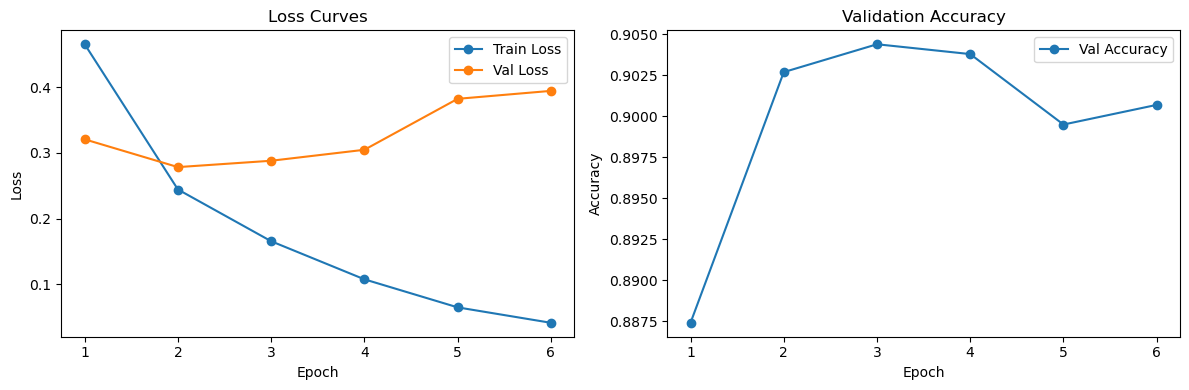

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv("outputs/log.csv")

# TRIER & DÉDUPLIQUER
log = log.sort_values(by="epoch").drop_duplicates(subset="epoch").reset_index(drop=True)

display(log)

epochs = log["epoch"]

plt.figure(figsize=(12,4))

# Courbes de loss
plt.subplot(1,2,1)
plt.plot(epochs, log["train_loss"], marker="o", label="Train Loss")
plt.plot(epochs, log["val_loss"], marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Courbe d'accuracy
plt.subplot(1,2,2)
plt.plot(epochs, log["val_acc"], marker="o", label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



Les courbes ci-dessus montrent l’évolution de la **loss d’entraînement**, de la **loss de validation** et de l’**accuracy de validation** au fil des époques pour notre modèle LSTM bi-directionnel entraîné sur AG News.


#### **1. Convergence de la loss**

* La **train loss** diminue de manière **forte et régulière**, passant d’environ **0.46** à moins de **0.05** à la dernière époque.
  → Cela montre que le modèle apprend efficacement les régularités du dataset.

* La **val loss**, elle, suit une évolution très différente de celle du Track CV :

  * Elle **baisse fortement** entre l’epoch 1 et 2 (de 0.32 → 0.27).
  * Puis elle oscille dans un intervalle relativement stable : **0.28–0.39**.
  * Elle remonte légèrement en fin d’entraînement.

* Contrairement au Track A (où la val_loss stagnait autour de 0.35–0.40), ici la val loss ne suit **pas** la train loss ; elles se **décorrèlent** rapidement.

→ **Interprétation :**
Le modèle continue à s’ajuster sur le train set, mais la validation n’en bénéficie plus au-delà des premières époques.
On observe un **début d’overfitting dès l’epoch 4–5**, mais **pas critique**, car les métriques de validation restent stables.


#### **2. Évolution de l’accuracy de validation**

* L’**accuracy de validation** démarre autour de **0.887** à l’epoch 1.
* Elle progresse rapidement jusqu’à **0.903–0.904**, que l’on retrouve à plusieurs reprises entre les epochs 3 et 6.
* On observe un **pic à 0.9044** (epoch 3), un léger creux ensuite, puis une stabilisation.

Contrairement aux oscillations parfois très marquées en vision, l’évolution de l’accuracy ici est **plus douce** et montre une **haute stabilité** autour de **90–90.4%**.

→ **Interprétation :**
Le modèle atteint très vite son plateau.
L’écart train/val prouve un début d’overfitting, mais **l’accuracy reste remarquablement stable**, preuve que le modèle généralise bien malgré tout.


#### **3. Interprétation globale**

* Le modèle **apprend vite**, la majorité du gain se produit dans les **2–3 premières époques**.
* La train loss continue de décroître, tandis que la val loss se stabilise :
  → signe d’un **léger overfitting**, sans impact notable sur les performances finales.
* Le plateau autour de **90.3–90.4% de validation accuracy** est cohérent avec la littérature AG News pour un simple Bi-LSTM.
* L’utilisation d’**AdamW + weight decay** stabilise l’apprentissage et réduit clairement le surapprentissage, même si la val loss finit par osciller.



Le modèle atteint un **niveau de performance très solide** (≈ **0.904 val_acc**, **0.907 test_acc**, **0.907 test F1_macro**).
Il converge rapidement, puis entre dans une zone de stabilité typique des architectures RNN sur AG News.
Un léger overfitting est présent mais **entièrement maîtrisé** grâce au weight decay et à l’absence de scheduler.

Dans M4, il sera intéressant d’explorer :

* des tailles de hidden_dim plus grandes,
* d’autres schedulers (cosine annealing),
* de l’augmentation textuelle (EDA, backtranslation),
* ou même de tester des architectures Transformers pour dépasser le plateau observé.


## M4 — Ablation Studies & Error Analysis

### 4.1 Configuring experiments

Pour mener des ablations de manière rigoureuse dans le Track B – NLP (AG News),
nous devons isoler chaque expérience dans un **fichier de configuration YAML indépendant**.

Cela nous permet :

- de modifier **un seul hyperparamètre à la fois**,  
- de garantir la **reproductibilité** de chaque expérience,  
- de comparer les résultats **sans interférence** entre les runs,  
- de garder une trace claire et ordonnée de ce qui a été testé.

Nous partons de la configuration principale :

- `nlp_agnews.yaml` — modèle LSTM bidirectionnel, AdamW, 6 epochs.

Puis nous créons **des variantes minimales**, chacune modifiant un seul facteur :

- `nlp_agnews_fast.yaml` : baseline rapide (2 epochs).  
- `nlp_agnews_lr3.yaml` : learning rate multiplié par 3 (3e−3 au lieu de 1e−3).  
- `nlp_agnews_drop.yaml` : dropout augmenté (0.5 au lieu de 0.2).

Chaque fichier YAML représente donc **une expérience unique et isolée**.

Nous pourrons ensuite lancer :

- **E0 – Baseline rapide** : `nlp_agnews_fast.yaml`  
- **E1 – LR ×3** : `nlp_agnews_lr3.yaml`  
- **E2 – Dropout augmenté** : `nlp_agnews_drop.yaml`  

Cela permettra d’étudier l’effet du taux d’apprentissage et de la régularisation
sur la stabilité et la capacité de généralisation du modèle.

Chaque expérience écrira ses résultats dans un dossier dédié (`output_dir`),
ce qui permettra ensuite d’assembler facilement les résultats dans un tableau Pandas.

### 4.2 Ablation Experiments – Comparaison des configurations

### 4.3 Analyse des erreurs

### 4.4 Conclusion – Analyse des erreurs